In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

root_dir = Path.cwd().parents[1]
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

# from caiman.utils.utils import load_dict_from_hdf5
from matplotlib import pyplot as plt


## Prepare & display data

/home/wollex/Data/Science/WolfGroup/PlaceFields/Programs/PC_analysis/placefield_dynamics/placefield_detection/utils/process_behavior.py:293: RuntimeWarning: Mean of empty slice.
  performance["RW_approach_space"][t, j] = vel_trial[pos_trial == p].mean()
/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


40


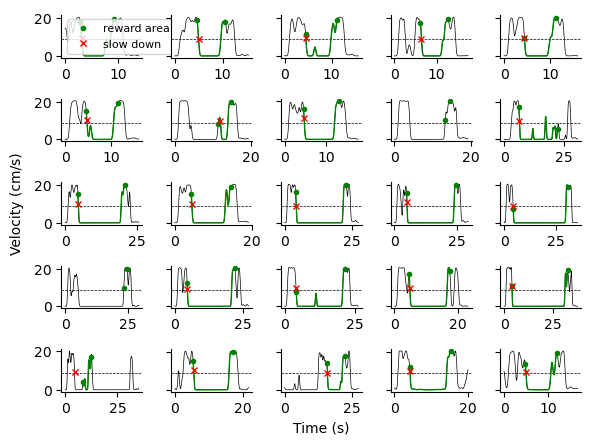

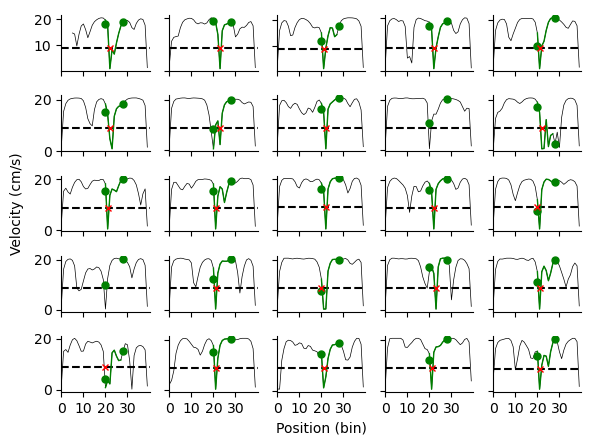

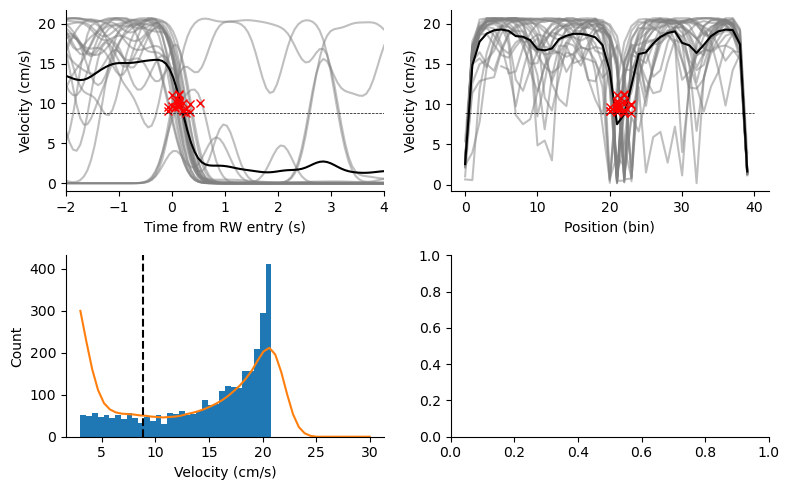

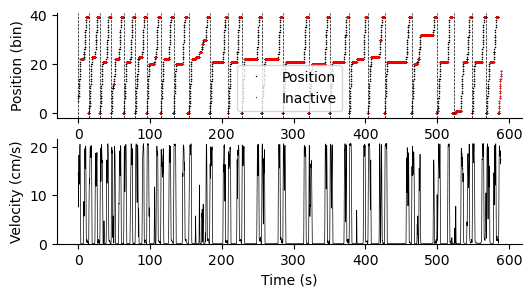

In [2]:
from placefield_detection.utils import prepare_behavior_from_file, plot_behavior

pathMouse = Path("../../../../data/845ad")
pathSession = pathMouse / "Session10"
f = 15.0
nbin = 40
only_active = True

pathBehavior = pathSession / "aligned_behavior.pkl"
behavior = prepare_behavior_from_file(
    pathBehavior,
    only_active=only_active,
    environment_length=120.0,
    nbin=nbin,
    f=15.0,
    T=None,
    calculate_performance=True,
    plt_bool=True,
    plt_trials=True,
)


plot_behavior(behavior)

In [3]:
from caiman.utils.utils import load_dict_from_hdf5
from placefield_detection.utils import prepare_activity, plot_activity

pathActivity = [
    file
    for file in pathSession.iterdir()
    if (
        file.stem.startswith("results_CaImAn")
        and not "compare" in file.stem
        and "redetected" in file.stem
    )
][0]

ld = load_dict_from_hdf5(pathActivity)

# neuron_activity = prepare_activity(
#     ld["S"][0, :],
#     behavior,
#     f=f,
#     only_active=only_active,
# )

/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-22 14:56:29.907229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761137789.923306  194576 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761137789.929004  194576 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


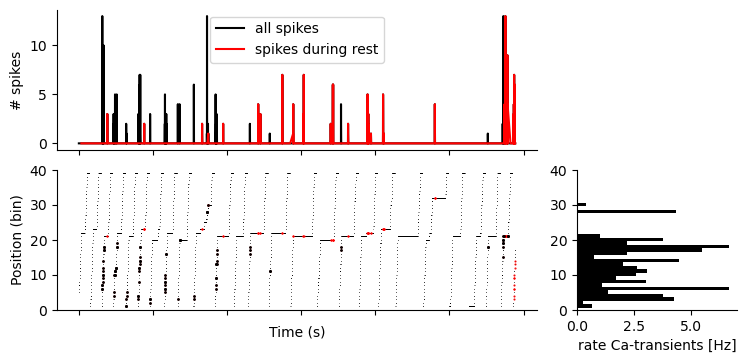

In [4]:
n = 0
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)
plot_activity(activity, behavior, f=f)

In [5]:
from placefield_detection.process_single_neuron import process_single_neuron
from placefield_detection.analyze_results import display_results
from placefield_detection.result_structures import handover_inference_results

process_neuron = process_single_neuron(
    behavior, ["peak", "information", "bayesian"], ["threshold", "bayesian"]
)
results = process_neuron.run_detection(neuron_activity[n, :], show_status=True, nP=12)
# inference_results["firingstats"] = {}
# for key in ["firing_rate","map_rates","map_trial_rates"]:
#     inference_results["firingstats"][key] = activity[key]

# N_f = 2
# results["bayesian"]["fields"] = handover_inference_results(results["bayesian"]["field_models"][N_f], results["bayesian"]["fields"])


n_field=0


n_field=1


n_field=2

Model comparison finished after 204.56s with evidences: 	 f=0 , logz=-1054.51	 f=1 , logz=-648.39	 f=2 *, logz=-534.79


{'A0': array([0.02429906]), 'fields': [place_field(A=array([9.7310862]), sigma=array([2.46516517]), theta=array([1.7794659 , 4.37281304, 7.40708227, 9.04628442, 3.09211198,
       6.27927746, 3.71811898, 7.35833516, 5.13154918, 4.75099091,
       7.59522998, 8.03083968, 5.59084745, 7.3334371 , 8.00863711,
       8.45690946, 7.80439227, 3.44265239, 7.14302808, 7.05165954,
       8.82717124, 3.70393299, 2.11000866, 4.08306731, 5.83806119]), reliability=1.0), place_field(A=array([15.75531958]), sigma=array([1.55825549]), theta=array([19.95128673, 25.20791854, 16.69905024, 17.78793789, 16.18473376,
       14.85178186, 24.32755596, 17.00112213, 19.38386784, 28.03822359,
       14.59367736, 16.08999387, 17.40038651, 12.00074173, 18.85369393,
       15.41779044, 17.01245593, 17.55689287, 13.47454008, 12.41633624,
       14.58914906, 14.55991708, 12.59332981, 26.7645409 , 19.51806993]), reliability=1.0)]}


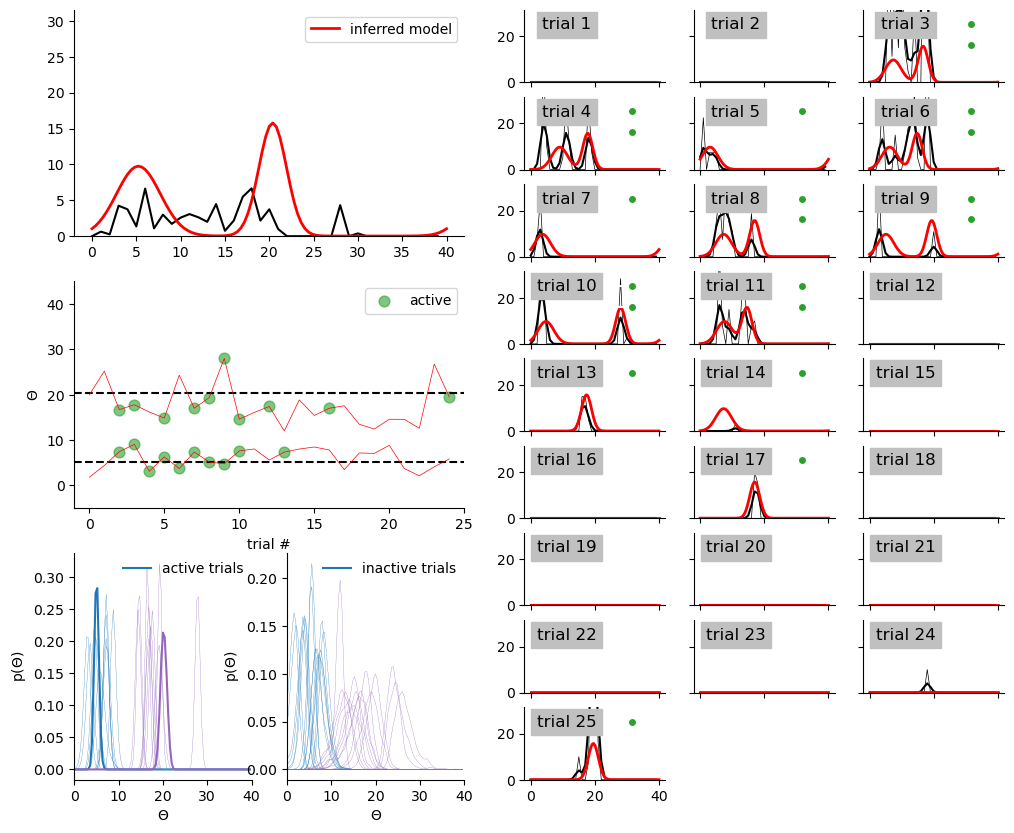

In [9]:
display_results(results)

## Test Bayes Hierarchical Method

In [14]:
import numpy as np
from placefield_detection.BayesModel import HierarchicalBayesInference
from placefield_detection.HierarchicalBayesModel import (
    parse_name_and_indices,
)
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)
from placefield_detection.result_structures import PlaceFieldInferenceResults

mode = "dynesty"
vectorized = mode == "ultranest"

activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)

HBI = HierarchicalBayesInference(logLevel="ERROR")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)
HBI.set_priors(N_f=1)
for key in HBI.priors.keys():
    param_name, indices = parse_name_and_indices(key, ["field", ""])
    print(f"{key:20s}, {param_name:15s}, {indices}")


# print(HBI.parameter_names_all)

"""
* make build results independent of HBI
* ensure param_names_all is replaced properly: in build_posterior, store_functions, etc
* ensure periodic is passed properly
* store x_arrays as 3-value tuple, instead of array (construct from scratch)
"""
# print(f"N_f:",res.N_f)
# print(res.fields["active_trials"].shape)

results = []
# for n_field in range(3):
n_field = 2
HBI.set_priors(N_f=n_field)

my_prior_transform = HBI.set_prior_transform(vectorized=vectorized)
my_likelihood = HBI.set_logp_func(vectorized=vectorized)

tmp_results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=12,
    n_live=100,
    periodic=HBI.periodic,
    mode=mode,
)
results.append(tmp_results)

A0                  , A0             , [None, None]
A_field0            , A              , [0, None]
sigma_field0        , sigma          , [0, None]
theta_field0_mean   , theta_mean     , [0, None]
theta_field0_sigma  , theta_sigma    , [0, None]
theta_field0        , theta          , [0, None]


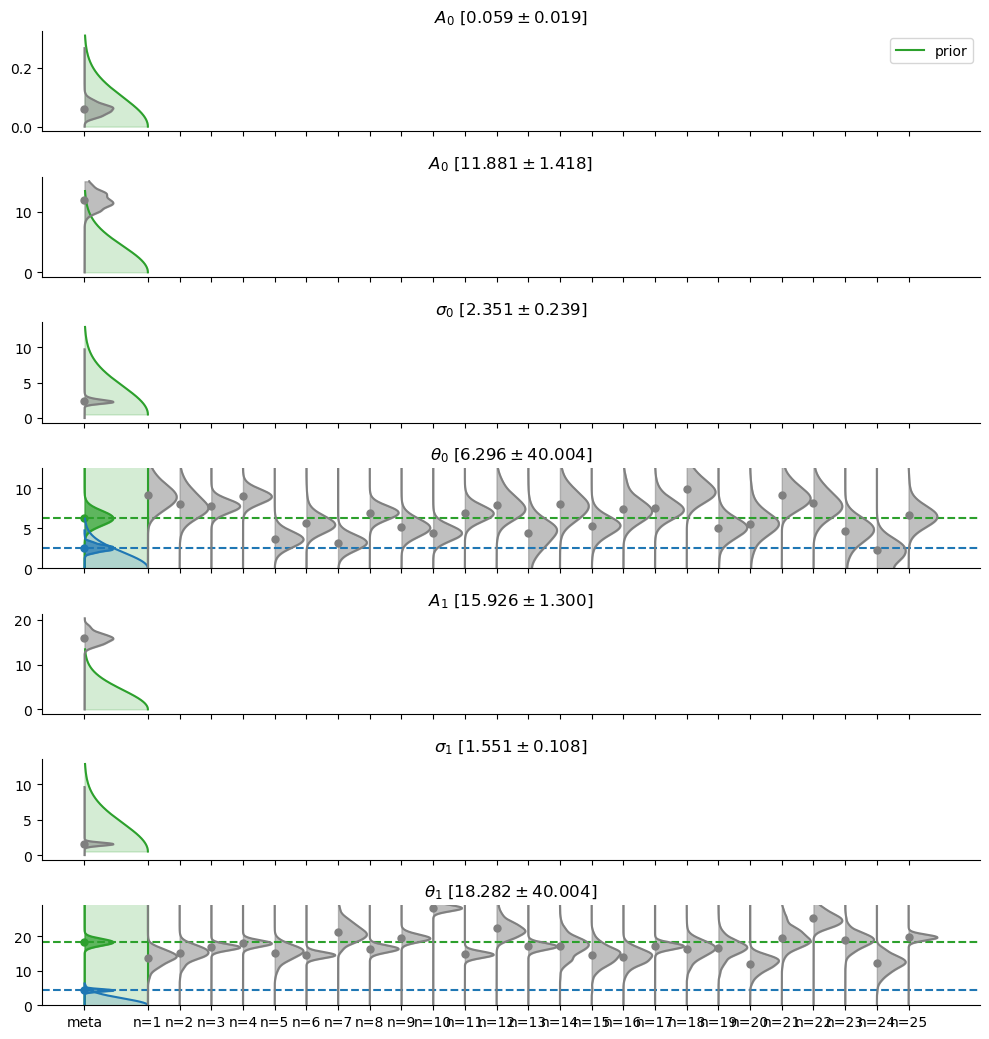

In [15]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    plot_results,
)

plot_results(HBI, tmp_results)

In [43]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    get_posterior_from_results,
    get_mean_from_samples,
)

posterior = get_posterior_from_results(tmp_results)
# posterior
# print(posterior["samples"].shape)
mean = get_mean_from_samples(
    posterior["samples"][:, 3], posterior["weights"], periodic=[0, 40]
)
mean

14.703298173102167

In [23]:
HBI.parameter_names_all[np.where([p is True for p in HBI.periodic])[0][0]]

'theta_field0_mean'

nan


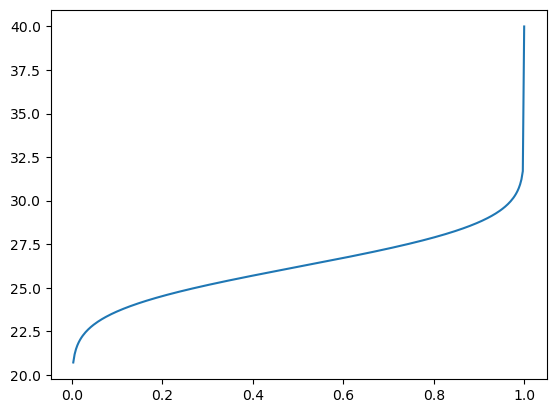

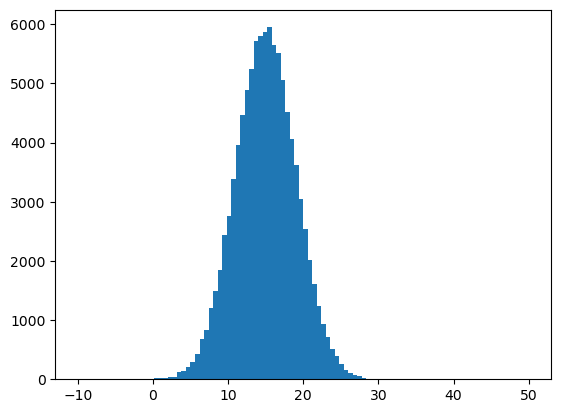

In [ ]:
from placefield_detection.HierarchicalBayesModel.functions import truncated_normal_ppf

min, max = -1.0, 2.0
x = np.linspace(min, max, steps := 1000)
trunc_norm = truncated_normal_ppf(x, mean=26.2, sigma=2.0, low=0.0, high=40.0)
print(trunc_norm.sum() / steps * (max - min))

plt.figure()
plt.plot(x, trunc_norm)
plt.show()

plt.figure()
plt.hist(
    truncated_normal_ppf(
        np.random.rand(100000), mean=15.0, sigma=4.0, low=0.0, high=40.0
    ),
    bins=np.linspace(-10, 50, 101),
)
plt.show()

In [8]:
results

[         nlive: 100
          niter: 4269
          ncall: array([1, 1, 1, ..., 1, 1, 1])
            eff: 0.5749781208256839
        samples: array([[ 1.68911334e-01,  6.91982211e-01,  3.46686286e+00, ...,
         -3.67186735e+00,  8.98435143e+00,  2.41790645e+00],
        [ 4.03057201e-03,  7.96583406e-01,  1.89426429e+00, ...,
         -4.53429613e+00,  6.81457296e+00,  2.73483960e+00],
        [ 1.62220691e-01,  6.92052199e-02,  2.79865048e+00, ...,
          4.39177296e+00,  2.96720026e+00,  1.92817019e+00],
        ...,
        [ 4.82298260e-02,  1.04884821e+01,  4.41705350e+00, ...,
          1.75695682e+01,  1.30649304e+01,  1.91438997e+01],
        [ 2.03969366e-02,  9.55459644e+00,  4.69702162e+00, ...,
          1.83617427e+01,  1.56340953e+01,  1.91028083e+01],
        [ 3.01586329e-02,  1.02665746e+01,  4.53933690e+00, ...,
          1.32100036e+01,  1.11538456e+01,  1.89078580e+01]])
           blob: array([None, None, None, ..., None, None, None], dtype=object)
     sa

In [ ]:
res = PlaceFieldInferenceResults(
    n_bin=HBI.n_bin, n_trials=HBI.n_samples, modes=["bayesian"]
)

n_field = 2
HBI.set_priors(N_f=n_field)
res.build_results(HBI.priors)

# print(res.periodic)
res.store_inference_results(
    results[n_field],
    HBI.parameter_names_all,
    periodic=HBI.periodic,
    logp=HBI.set_logp_func(vectorized=False),
)
res.fields

{'n_modes': array(2),
 'parameter': {'global': {'A0': array([0.07826828, 0.02811796, 0.12061489]),
   'A': array([[2.76713529e-02, 2.00650748e-03, 7.89626777e-02],
          [2.00919953e+01, 1.84612588e+01, 2.17347146e+01]]),
   'sigma': array([[2.10340458, 1.08416444, 3.29972835],
          [3.92501291, 3.76526792, 4.10199922]]),
   'theta_mean': array([[ 2.16209819,  0.55881667,  3.8741335 ],
          [20.80576423, 19.99567802, 21.6461243 ]]),
   'theta_sigma': array([[0.72902669, 0.08225354, 1.57766087],
          [3.22880462, 2.60467523, 4.17274358]]),
   'theta': array([[ 2.16209819,  0.55881667,  3.8741335 ],
          [20.80576423, 19.99567802, 21.6461243 ]])},
  'local': {'theta': array([[[ 2.6009268 ,  0.55688683,  4.80293961],
           [ 2.10258128,  0.49296971,  4.06153237],
           [ 1.54578685,  0.25491411,  3.13020666],
           [ 1.92079706,  0.35680581,  4.01343286],
           [ 1.98719002,  0.37590482,  3.91203731],
           [ 1.98039695,  0.34226417,  4.152

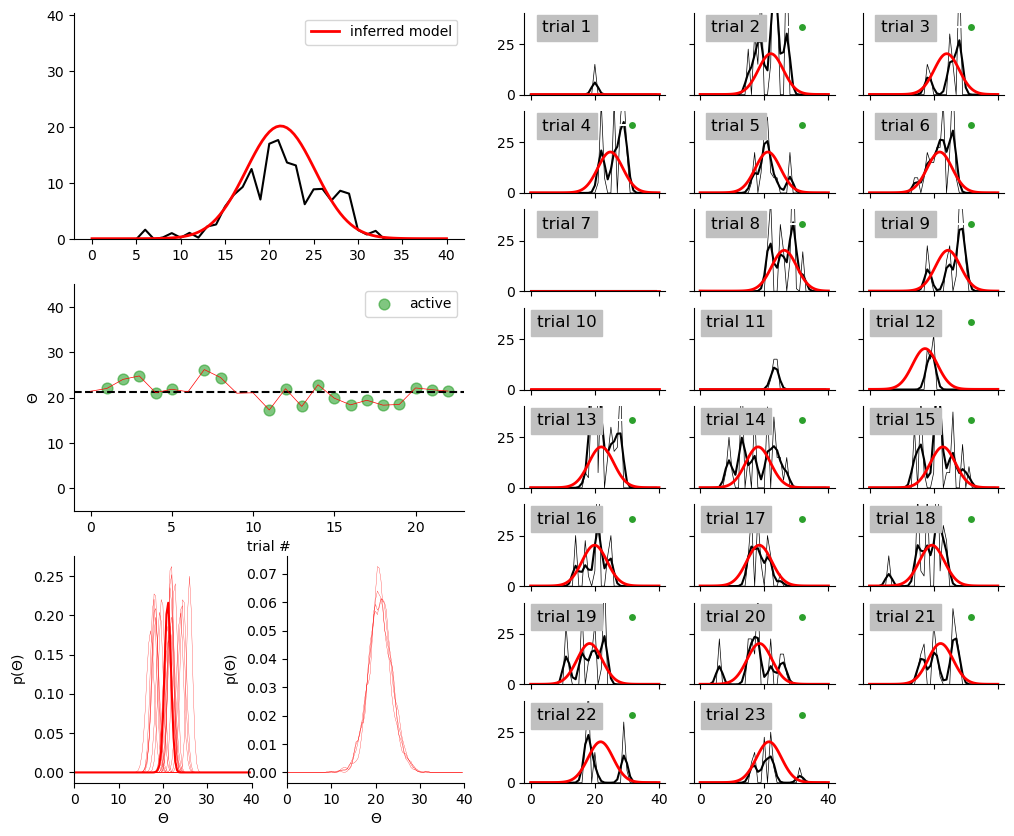

'\n* write logic to automatically assign "winning model"\n* write logic to assing firingstats, etc\n* incorporate in "process_session"\n* run on data! \n'

In [ ]:
from placefield_detection.result_structures import (
    PlaceFieldInferenceResults,
    build_results,
    handover_inference_results,
    extract_inference_results,
)

# from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import plot_results
from placefield_detection.analyze_results import display_results

n_cells = 1
n = 0
res = PlaceFieldInferenceResults(n_bin=HBI.n_bin, n_trials=HBI.n_samples)

HBI.set_priors(N_f=0)
overall_res = build_results(
    n_cells=n_cells,
    n_bin=HBI.n_bin,
    n_trials=HBI.n_samples,
    modes=["bayesian", "threshold"],
)

N_f = 2
overall_res["bayesian"]["field_models"]["logz"] = np.zeros(
    (n_cells,) if n_cells > 1 else () + (N_f + 1, 2)
)  # n_cells, n_field_models, (logz, logz_err)

n = n if n_cells > 1 else None
for n_field in range(3):
    HBI.set_priors(N_f=n_field)
    res.build_results(priors=HBI.priors)
    res.store_inference_results(
        results[n_field],
        HBI.parameter_names_all,
        periodic=HBI.periodic,
        logp=HBI.set_logp_func(vectorized=False),
    )

    overall_res["bayesian"]["field_models"][n_field] = res.fields
    # handover_inference_results(res.fields, overall_res["bayesian"]["field_models"][n_field], idx=n if n_cells>1 else None)

    # hand over logz to joint results for easier comparison
    overall_res["bayesian"]["field_models"]["logz"][n_field, :] = overall_res[
        "bayesian"
    ]["field_models"][n_field][
        "logz"
    ]  # [n,:]

for key in ["firing_rate", "map_rates", "map_trial_rates"]:
    overall_res["firingstats"][key][n, ...] = activity[key]

## set "winning model"
res.build_results(priors=HBI.priors)

overall_res["bayesian"]["fields"] = res.fields
overall_res["bayesian"]["fields"] = handover_inference_results(
    overall_res["bayesian"]["field_models"][1],
    overall_res["bayesian"]["fields"],
    idx=n if n_cells > 1 else None,
)

# overall_res["bayesian"]["field_models"][1]
# plot_results(HBI, results[n_field], mode="dynesty")

# single_res = extract_inference_results(overall_res,1)
# single_res["bayesian"]["field_models"][1]
display_results(overall_res, n)


"""
* write logic to assing firingstats, etc
* incorporate in "process_session"
* check reliability penalty!!
* run on data! 
"""

In [17]:
from placefield_detection.BayesModel import model_comparison

n = 0
neuron_activity = ld["S"].copy()
activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)

inference_results = model_comparison(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    show_status=True,
    nP=12,
    # mode="dynesty"
)


n_field=0


n_field=1


n_field=2

Model comparison finished after 18.08s with evidences: 	 f=0 , logz=-296.34	 f=1 , logz=-108.29	 f=2 *, logz=-93.75


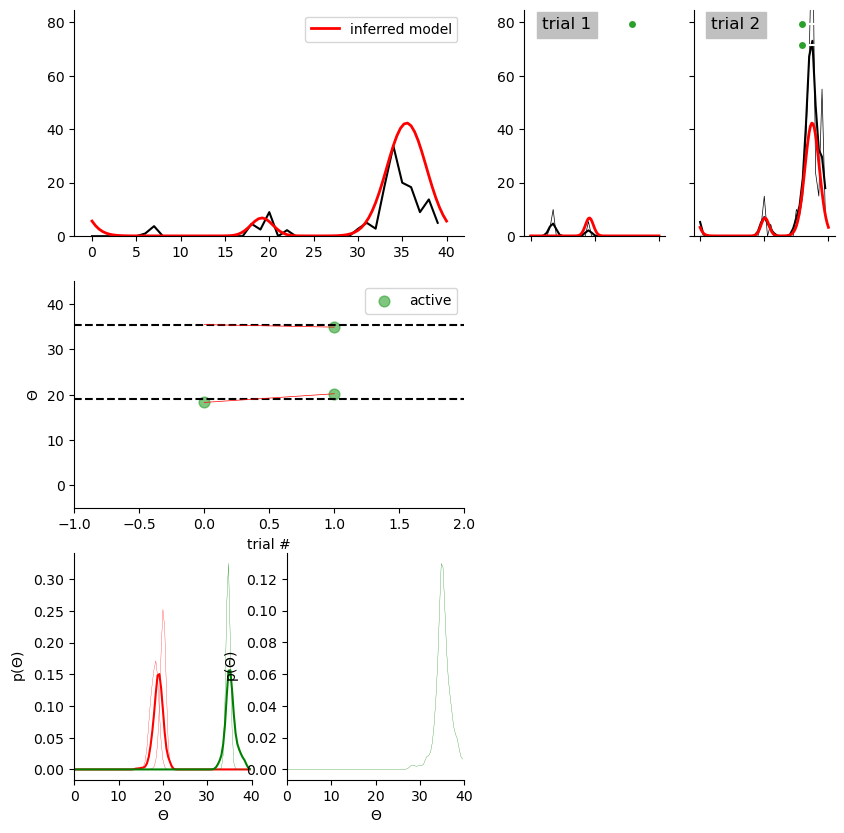

{'n_modes': array(2),
 'parameter': {'global': {'A0': array([0.11569423, 0.0399242 , 0.21168075]),
   'A': array([[ 6.72073219,  3.50100166, 11.10341163],
          [42.22959644, 34.54210419, 11.74121377]]),
   'sigma': array([[1.23139396, 0.80323157, 1.79398102],
          [2.23471972, 2.01704127, 2.46525351]]),
   'theta_mean': array([[19.16389997, 17.45052927, 20.87240356],
          [35.4954444 , 33.68269175, 37.82478021]]),
   'theta_sigma': array([[1.63661435, 0.4635125 , 3.26135108],
          [1.22587982, 0.15554086, 2.80744391]]),
   'theta': array([[19.16389997, 17.45052927, 20.87240356],
          [35.4954444 , 33.68269175, 37.82478021]])},
  'local': {'theta': array([[[18.29744928, 16.9818465 , 19.49538197],
           [20.21710055, 19.35537846, 20.94698553]],
   
          [[35.48009845, 32.66107158, 38.68283237],
           [34.9224258 , 34.50435373, 35.33055141]]])}},
 'p_x': {'global': {'A0': array([0.02135927, 0.04933678, 0.08760273, 0.12193512, 0.14744911,
          0

In [33]:
from placefield_detection.analyze_results import display_results
from placefield_detection.result_structures import build_results

results = build_results(
    n_cells=1, n_bin=HBI.n_bin, n_trials=HBI.n_samples, modes=["bayesian", "threshold"]
)
results["bayesian"] = inference_results
results["firingstats"] = {}
for key in ["firing_rate", "map_rates", "map_trial_rates"]:
    results["firingstats"][key] = activity[key]
# print(results["bayesian"]["fields"])
# inference_results
display_results(results)
inference_results["fields"]

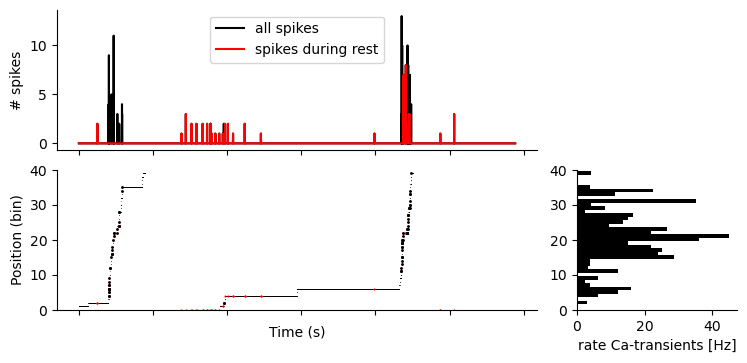

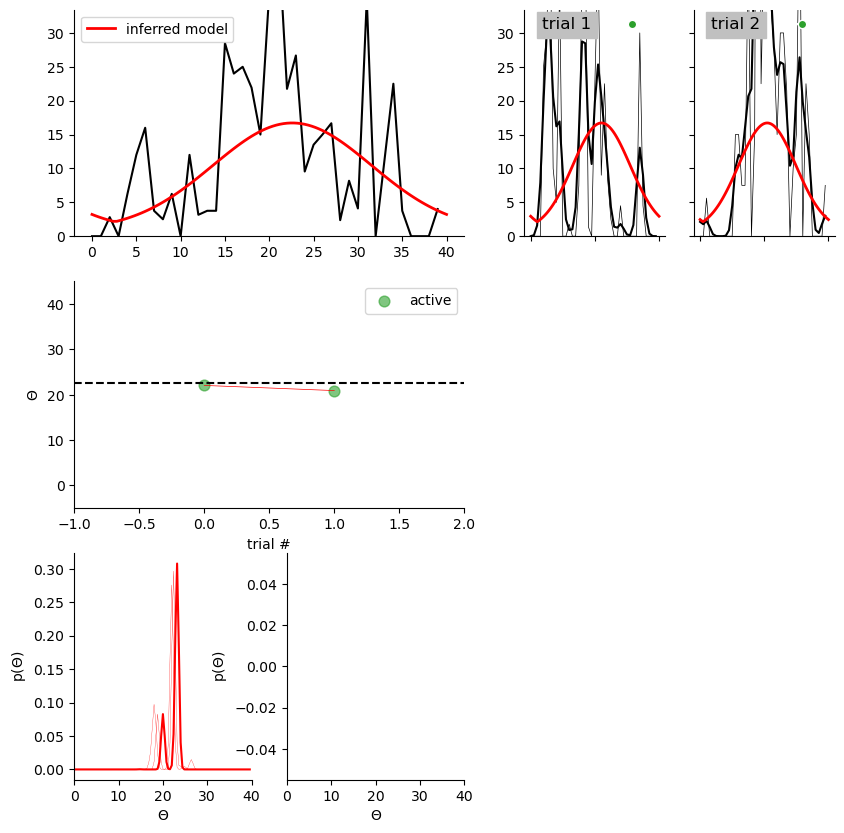

{'firingstats': {'firing_rate': 0.5456669262431861,
  'map_rates': array([ 0.        ,  0.        ,  2.8125    ,  0.        ,  6.25      ,
         12.        , 16.        ,  3.75      ,  2.5       ,  6.25      ,
          0.        , 12.        ,  3.15789474,  3.75      ,  3.75      ,
         28.5       , 24.        , 25.        , 21.92307692, 15.        ,
         36.        , 45.        , 21.75      , 26.66666667,  9.54545455,
         13.5       , 15.        , 16.66666667,  2.36842105,  8.18181818,
          4.09090909, 35.        ,  0.        , 11.25      , 22.5       ,
          3.75      ,  0.        ,  0.        ,  0.        ,  4.        ]),
  'map_trial_rates': array([[         nan,   0.        ,   0.        ,   0.        ,
           25.        ,  30.        ,  48.        ,  10.        ,
            5.        ,  37.5       ,   0.        ,   0.        ,
            1.76470588,   0.        ,   0.        ,   7.5       ,
           40.        ,  45.        ,   1.36363636,   0.  

In [32]:
from placefield_detection.analyze_results import display_results
from placefield_detection.result_structures import handover_inference_results

# inference_results["firingstats"] = {}
# for key in ["firing_rate","map_rates","map_trial_rates"]:
#     inference_results["firingstats"][key] = activity[key]

# N_f = 2
# results["bayesian"]["fields"] = handover_inference_results(results["bayesian"]["field_models"][N_f], results["bayesian"]["fields"])

activity = prepare_activity(neuron_activity[n, :], behavior, f=15.0, only_active=True)
plot_activity(activity, behavior, f=f)
display_results(results)
results

In [75]:
from placefield_detection.BayesModel import HierarchicalBayesInference
import numpy as np

HBI = HierarchicalBayesInference(logLevel="DEBUG")
HBI.prepare_data(
    activity["map_trial_spikes"],
    behavior["trials"]["dwelltime"],
    iter_dims=False,
    dimension_names=["trials", "position_bins"],
)

HBI.set_priors(N_f=2)

In [10]:
model = 2
print(results["bayesian"]["field_models"][model]["parameter"])

p_good = np.zeros((len(HBI.parameter_names_all),))
p_good[0] = results["bayesian"]["field_models"][model]["parameter"]["global"]["A0"][0]
p_good[[1, 7]] = results["bayesian"]["field_models"][model]["parameter"]["global"]["A"][
    :2, 0
]
p_good[[2, 8]] = results["bayesian"]["field_models"][model]["parameter"]["global"][
    "sigma"
][:2, 0]
p_good[[3, 9]] = results["bayesian"]["field_models"][model]["parameter"]["global"][
    "theta"
][:2, 0]
p_good[[4, 10]] = results["bayesian"]["field_models"][model]["parameter"]["global"][
    "theta_sigma"
][:2, 0]

p_good[[5, 11]] = results["bayesian"]["field_models"][model]["parameter"]["local"][
    "theta"
][:2, 0, 0]
p_good[[6, 12]] = results["bayesian"]["field_models"][model]["parameter"]["local"][
    "theta"
][:2, 1, 0]
p_good

{'global': {'A0': array([0.12046191, 0.05039739, 0.22272753]), 'A': array([[ 7.11305104,  3.3038528 , 11.71405464],
       [44.40241598, 35.73104687, 14.89366843]]), 'sigma': array([[1.26181141, 0.78991519, 1.83716728],
       [2.20018237, 1.97177493, 2.46930625]]), 'theta_mean': array([[19.32940665, 17.44453309, 21.29147247],
       [35.13531494, 33.51101849, 37.23262252]]), 'theta_sigma': array([[1.64909665, 0.42504771, 3.31071338],
       [1.48731291, 0.18131901, 3.56948962]]), 'theta': array([[19.32940665, 17.44453309, 21.29147247],
       [35.13531494, 33.51101849, 37.23262252]])}, 'local': {'theta': array([[[18.30723719, 16.96064467, 19.51108451],
        [20.22513983, 19.33677107, 21.02064636]],

       [[35.49553107, 32.83162797, 39.4322202 ],
        [34.93852924, 34.52551737, 35.34850541]]])}}


array([ 0.12046191,  7.11305104,  1.26181141, 19.32940665,  1.64909665,
       18.30723719, 20.22513983, 44.40241598,  2.20018237, 35.13531494,
        1.48731291, 35.49553107, 34.93852924])

In [80]:
p = np.random.rand(HBI.n_params)

my_prior_transform = HBI.set_prior_transform(vectorized=False)
my_likelihood = HBI.set_logp_func(vectorized=False)


p_transformed = my_prior_transform(p)
# print(p_transformed)
my_likelihood(p_transformed)
# my_likelihood(p_good)

# %timeit my_likelihood(p_transformed)
# params = HBI.get_params_from_p(p_transformed)
# build_distr_structure_from_params(params, "field", place_field)

DEBUG:nestLogger:time for transforming parameters: 69.86
DEBUG:nestLogger:time for tuning curve model: 246.29
DEBUG:nestLogger:time for poisson: 352.14
DEBUG:nestLogger:time for infield ranges: 118.73
DEBUG:nestLogger:time for active model: 349.52
DEBUG:nestLogger:time for raw logp: 19.55
DEBUG:nestLogger:time for overlap penalty: 142.81
DEBUG:nestLogger:time for reliability penalty: 160.22
DEBUG:nestLogger:time for lower_bound_0 penalty: 65.33
DEBUG:nestLogger:time for ordered fields penalty: 18.36
DEBUG:nestLogger:time for penalties: 11.21


calculate penalty multiplier from difference between 1 and 2 fields (change names!)!
Also, check whether factor is properly calculated to yield 1 if completely within


-653772922.4849519

In [208]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)

HBI.set_logLevel("ERROR")
results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=1,
    n_live=100,
    periodic=HBI.periodic,
    mode="dynesty",
)

reliability_penalty: [0.]
reliability_penalty: [0.]
reliability_penalty: [0.]
reliability_penalty: [0.]
reliability_penalty: [0.47253607]
reliability_penalty: [45.30338914]
reliability_penalty: [110.99219407]
reliability_penalty: [0.]
reliability_penalty: [8.24250979]
reliability_penalty: [0.]
reliability_penalty: [182.98426669]
reliability_penalty: [0.]
reliability_penalty: [97.04691791]
reliability_penalty: [9.96363388]
reliability_penalty: [82.94256757]
reliability_penalty: [188.51028337]
reliability_penalty: [78.77965508]
reliability_penalty: [45.38136246]
reliability_penalty: [115.68109213]
reliability_penalty: [0.]
reliability_penalty: [22.7041831]
reliability_penalty: [0.]
reliability_penalty: [230.90712772]
reliability_penalty: [106.75954161]
reliability_penalty: [100.25516956]
reliability_penalty: [70.6473026]
reliability_penalty: [0.]
reliability_penalty: [522.37297752]
reliability_penalty: [335.69861972]
reliability_penalty: [175.44186919]
reliability_penalty: [43.13772511]


Traceback (most recent call last):
  File "/home/wollex/miniforge3/envs/caiman/lib/python3.11/site-packages/dynesty/dynesty.py", line 913, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 40, in get_logp
  File "<string>", line 7, in obtain_active_model
  File "<string>", line 11, in compute_AIC
KeyboardInterrupt


KeyboardInterrupt: 

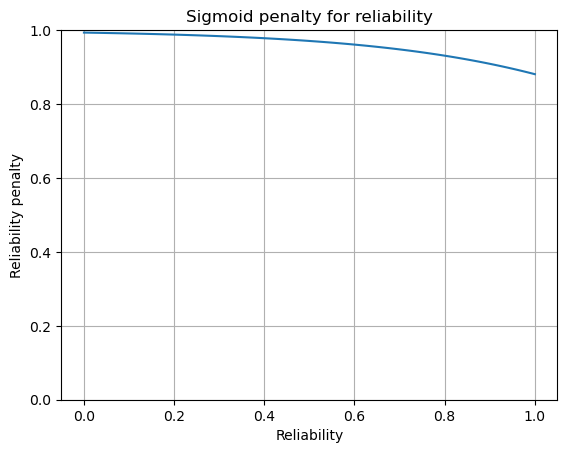

In [27]:
from scipy.special import binom
import numpy as np
from matplotlib import pyplot as plt

from placefield_detection.BayesModel import reliability_sigmoid

# p_chance = 1./10 # probability to observe localized activity at place field location by chance

theta_n = 5
n = 3
k_array = np.arange(0, n + 1)
# binom(n,k_array) * p_chance**k_array * (1-p_chance)**(n-k_array)


x_arr = np.linspace(0, 1, 101)
# reliability_sigmoid = lambda x,threshold,slope: (1 - 1 / (1 + np.exp(-slope * (x - threshold))))

# penalty_2 = np.maximum(5-k_array,0)/5

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
if theta_n < n:
    ax.axvline(theta_n / n, color="gray", ls="--")
ax.plot(x_arr, reliability_sigmoid(x_arr, n, theta_n))
# ax.plot(k_array/n, reliability_sigmoid(k_array/n,k_array), 'ok')
# ax.plot(k_array/n, penalty_2, 'o')

# ax.plot(k_array/n, reliability_sigmoid(k_array/n) * penalty_2, 'o')

# ax.plot(k_array/n, binom(n,k_array) * p_chance**k_array * (1-p_chance)**(n-k_array), 'ok')
plt.setp(ax, ylim=[0, 1])
ax.set_xlabel("Reliability")
ax.set_ylabel("Reliability penalty")
ax.set_title("Sigmoid penalty for reliability")
ax.grid()
plt.show()

In [39]:
HBI.dimensions

{'shape': (23, 40), 'n': 2, 'names': ['trials', 'position_bins']}

In [10]:
from placefield_detection.HierarchicalBayesModel.NestedSamplingMethods import (
    run_sampling,
)

mode = "dynesty"
vectorized = mode == "ultranest"
my_prior_transform = HBI.set_prior_transform(vectorized=vectorized)
my_likelihood = HBI.set_logp_func(vectorized=vectorized)

results, sampler = run_sampling(
    my_prior_transform,
    my_likelihood,
    HBI.parameter_names_all,
    nP=12,
    n_live=100,
    periodic=HBI.periodic,
    mode=mode,
)

running nested sampling


4156it [00:44, 94.10it/s, +100 | bound: 85 | nc: 1 | ncall: 670576 | eff(%):  0.635 | loglstar:   -inf < -957.740 <    inf | logz: -999.345 +/-  0.689 | dlogz:  0.013 >  1.000]


In [11]:
results.summary()

Summary
nlive: 100
niter: 4156
ncall: 670476
eff(%):  0.635
logz: -999.345 +/-  1.225


In [ ]:
"""
* change dwelltime_trials to be in toplevel
"""

'\n* change dwelltime_trials to be in toplevel\n* change bayesModel to not contain storing functions, but move these to separate utils\n'

In [269]:
from placefield_detection.result_structures import (
    PlaceFieldInferenceResults,
)

# from placefield_detection.result_structures import build_inference_results

res = PlaceFieldInferenceResults(HBI)
post = res.store_inference_results(results)

In [266]:
models = []
for n in range(3):
    models.append(PlaceFieldInferenceResults(HBI, N_f=n))

In [ ]:
res.fields["parameter"]["global"]["theta_mean"]

from sys import getsizeof


def get_nested_dict_bitsize(d):
    """Recursively get the total bit size of a nested dictionary."""
    size = getsizeof(d)
    if isinstance(d, dict):
        for v in d.values():
            size += get_nested_dict_bitsize(v)
    elif isinstance(d, (list, tuple)):
        for v in d:
            size += get_nested_dict_bitsize(v)

    return size


# Convert bytes to human-readable format
def human_readable_size(num_bytes):
    for unit in ["bytes", "KB", "MB", "GB", "TB"]:
        if num_bytes < 1024:
            return f"{num_bytes:.2f} {unit}"
        num_bytes /= 1024
    return f"{num_bytes:.2f} PB"


# Example usage:
bitsize = get_nested_dict_bitsize(res.fields)
byte = human_readable_size(bitsize)
print(f"Total byte size of res.fields: {byte}")

Total byte size of res.fields: 26.89 KB


In [274]:
from placefield_detection.result_structures import build_results

overall_res = build_results(
    n_cells=3,
    n_bin=HBI.n_bin,
    n_trials=HBI.n_samples,
    modes=["bayesian", "threshold"],
    HBI=HBI,
    N_f=2,
)

bitsize = get_nested_dict_bitsize(overall_res)
byte = human_readable_size(bitsize)
print(f"Total byte size of res.fields: {byte}")

Total byte size of res.fields: 243.02 KB


In [277]:
overall_res["bayesian"]["field_models"][2]

{'n_modes': array([2, 2, 2]),
 'parameter': {'global': {'A0': array([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
   'A': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'sigma': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta_mean': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta_sigma': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]]),
   'theta': array([[[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.]]])},

In [253]:
from placefield_detection.result_structures import (
    extract_inference_results,
    handover_inference_results,
)

# overall_res["bayesian"]["fields"]["parameter"]["global"].keys()
idx = 1
overall_res["bayesian"]["fields"] = handover_inference_results(
    res.fields, overall_res["bayesian"]["fields"], idx=idx
)
overall_res["bayesian"]["fields"]["parameter"]["global"]["theta_mean"]

print(
    "store all results (from N_f=0,1,2) into results structure such that reanalysis can be done without completely rerunning everything"
)

n_modes into fitting array
parameter dict_keys(['global', 'local'])
global dict_keys(['A0', 'A', 'sigma', 'theta_mean', 'theta_sigma', 'theta'])
A0 into fitting array
A into larger array
sigma into larger array
sizes theta_mean: 3 6
theta_mean into larger array
theta_sigma into larger array
theta into larger array
local dict_keys(['theta'])
theta into larger array
p_x dict_keys(['global', 'local'])
global dict_keys(['A0', 'A', 'sigma', 'theta_mean', 'theta_sigma'])
A0 into fitting array
A into larger array
sigma into larger array
sizes theta_mean: 100 200
theta_mean into larger array
theta_sigma into larger array
local dict_keys(['theta'])
theta into larger array
logz into fitting array
active_trials into larger array
reliability into larger array
store all results (from N_f=0,1,2) into results structure such that reanalysis can be done without completely rerunning everything


In [258]:
print(res.fields["logz"].shape)
overall_res["bayesian"]["fields"].keys()

(2,)


dict_keys(['n_modes', 'parameter', 'p_x', 'x', 'logz', 'active_trials', 'reliability'])

In [217]:
overall_res["bayesian"]["fields"]["parameter"]["local"]

{'theta': array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        

In [77]:
my_trafo = HBI.set_prior_transform(vectorized=False)
my_trafo(p[0:1, :])

KeyError: 'mean'

In [188]:
HBI.priors["theta_field0_mean"]["n"]

1

In [38]:
tmp_results

         nlive: 100
         niter: 4269
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 0.5749781208256839
       samples: array([[ 1.68911334e-01,  6.91982211e-01,  3.46686286e+00, ...,
        -3.67186735e+00,  8.98435143e+00,  2.41790645e+00],
       [ 4.03057201e-03,  7.96583406e-01,  1.89426429e+00, ...,
        -4.53429613e+00,  6.81457296e+00,  2.73483960e+00],
       [ 1.62220691e-01,  6.92052199e-02,  2.79865048e+00, ...,
         4.39177296e+00,  2.96720026e+00,  1.92817019e+00],
       ...,
       [ 4.82298260e-02,  1.04884821e+01,  4.41705350e+00, ...,
         1.75695682e+01,  1.30649304e+01,  1.91438997e+01],
       [ 2.03969366e-02,  9.55459644e+00,  4.69702162e+00, ...,
         1.83617427e+01,  1.56340953e+01,  1.91028083e+01],
       [ 3.01586329e-02,  1.02665746e+01,  4.53933690e+00, ...,
         1.32100036e+01,  1.11538456e+01,  1.89078580e+01]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([23

In [122]:
hierarchical = set(key.split("_")[0] for key in HBI.priors if HBI.priors[key]["n"] > 1)


# for key in HBI.priors:
#     # print(prior)
#     # print(key)
#     # print(HBI.priors[key])
#     if HBI.priors[key]["n"]>1:
#         hierarchical.add(key.split("_")[0])
#         # print("hierarchical prior:", key)
#         # print(HBI.priors[key])

print("hierarchical parameters:", hierarchical)

hierarchical parameters: {'theta'}


In [14]:
from HierarchicalBayesModel.NestedSamplingMethods import get_mean_from_sampler

mean_params = get_mean_from_sampler(results, HBI.parameter_names_all, mode="dynesty")
mean_params

{'A0': 0.8291649608950189,
 'A_field0': 11.204315010909365,
 'sigma_field0': 9.912761597997502,
 'theta_field0_mean': 6.618661336767071,
 'theta_field0_sigma': 2.9571611939258333,
 'theta_field0_0': 8.31702998095772,
 'theta_field0_1': 6.119185466713095,
 'theta_field0_2': 4.877277962090751,
 'theta_field0_3': 7.443252326797312,
 'theta_field0_4': 8.319492083513529,
 'theta_field0_5': 5.833135353771624,
 'theta_field0_6': 10.679114611761081,
 'theta_field0_7': 11.427995312762734,
 'theta_field0_8': 8.025557999754426,
 'theta_field0_9': 6.907411667093027,
 'theta_field0_10': 7.62130549022297,
 'theta_field0_11': 6.552897964954164,
 'theta_field0_12': 7.4764742351754245,
 'theta_field0_13': 5.548779478047613,
 'theta_field0_14': 7.20486384140955,
 'theta_field0_15': 6.190056256709406,
 'theta_field0_16': 5.383625949541594,
 'theta_field0_17': 7.232614619527937,
 'theta_field0_18': 5.889431221616995,
 'theta_field0_19': 5.789733318207356,
 'theta_field0_20': 4.527456066697092,
 'theta_fie

In [17]:
results.samples[-20:, -5:]

array([[4.62121247, 4.52365395, 2.78268409, 5.14947098, 1.30724013],
       [4.61834574, 4.52213311, 2.77850376, 5.14611453, 1.30222201],
       [4.61834546, 4.52213284, 2.77850343, 5.14611422, 1.30222135],
       [4.96377932, 4.86337367, 3.71296177, 5.70529587, 2.7815834 ],
       [4.61834388, 4.52213134, 2.77850156, 5.14611272, 1.30221851],
       [4.94466314, 4.84474624, 3.69213478, 5.68618093, 2.75544011],
       [4.96376465, 4.86335949, 3.71295208, 5.7052876 , 2.78156752],
       [4.61834388, 4.52213134, 2.77850157, 5.14611272, 1.3022185 ],
       [4.94466315, 4.84474624, 3.69213479, 5.68618094, 2.75544011],
       [4.94551305, 4.8453759 , 3.6928941 , 5.68682287, 2.75677846],
       [4.96377932, 4.86337368, 3.71296178, 5.70529588, 2.78158341],
       [4.94551305, 4.8453759 , 3.6928941 , 5.68682287, 2.75677846],
       [4.94466385, 4.84474684, 3.69213509, 5.68618119, 2.75544107],
       [4.61834527, 4.52213266, 2.7785032 , 5.14611405, 1.30222096],
       [4.94466379, 4.84474677, 3.

## Test other methods

p_value p_value


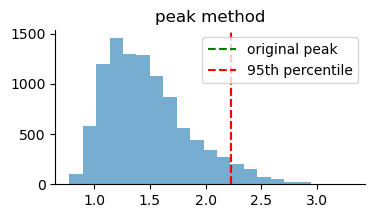

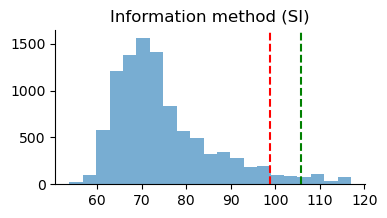

In [6]:
from placefield_detection.alternative_detection_methods import (
    peak_method,
    information_method,
)

neuron = 11
neuron_activity = ld["S"][:, behavior["active"]]
shuffles = 10000
is_pc, p_val = peak_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
is_pc, p_val_info = information_method(
    behavior, neuron_activity[neuron, :], shuffles, False, plot=True
)
print(p_val, p_val_info)

In [7]:
from placefield_detection.alternative_detection_methods import (
    peak_method_batch,
    information_method_batch,
    # stability_method,
)

print(neuron_activity.shape)
# information_method(
#     behavior,
#     neuron_activity[0, :],
#     n_shuffles=10000,
#     plot=True,
# )

# results_info = information_method_batch(
#     behavior,
#     neuron_activity,
#     n_shuffles=10000,
# )
is_place_cell, p_value = peak_method_batch(
    behavior,
    neuron_activity,
    n_shuffles=10000,
)
# stability_method(
#     behavior,
#     neuron_activity,
#     neurons,
#     nbin,
# )

(848, 2855)


100%|██████████| 848/848 [00:51<00:00, 16.53it/s]


TypeError: list indices must be integers or slices, not str

In [ ]:
from placefield_detection.utils import (
    get_firingmap,
    obtain_significant_events_from_one_sided_process,
)

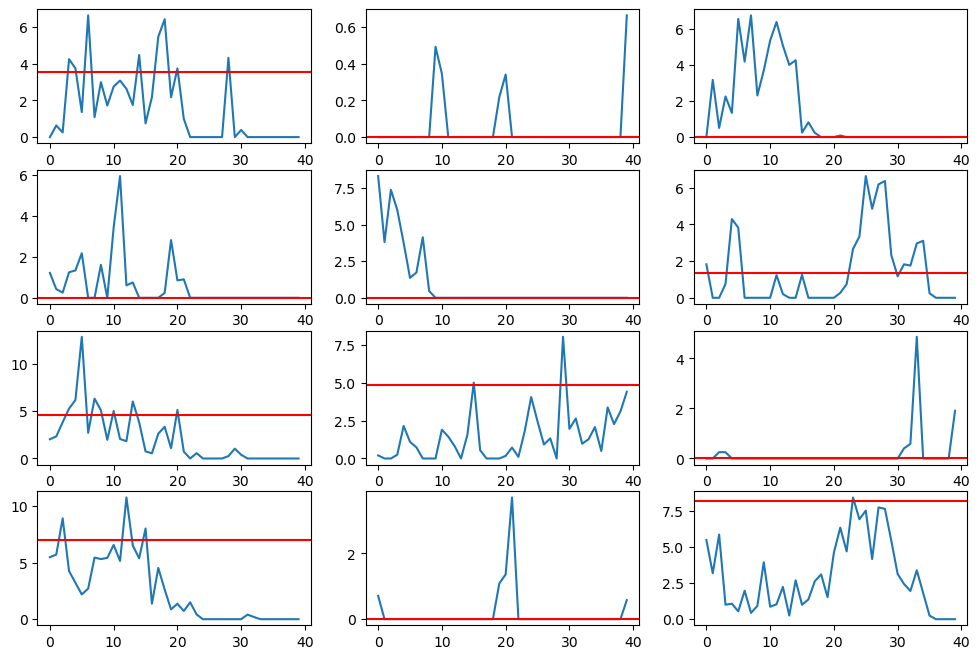

In [ ]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 3, figsize=(12, 8))

for neuron in range(12):

    activity = prepare_activity(
        neuron_activity[neuron, :], behavior, f=f, only_active=only_active
    )

    fmap = get_firingmap(
        activity["spikes"],
        behavior["position"],
        behavior["dwelltime"],
        nbin=behavior["nbin"],
    )
    # frate, threshold, _ = get_firingrate(neuron_activity[0,:],IQR=True)
    field, threshold, sd_r = obtain_significant_events_from_one_sided_process(
        fmap, baseline_mode="percentile", sd_mode="iqr", prctile=50
    )
    # print("sd_r:", sd_r)
    # baseline_prc, sd = estimate_stats_from_one_sided_process(fmap, "percentile", "iqr")
    # print("\n")
    # frate, threshold, PF = get_firingrate(fmap, sd_r=-1, IQR=False)
    # frate, threshold_IQR, PF = get_firingrate(fmap, sd_r=-1, IQR=True)

    ax = axes[neuron // 3, neuron % 3]
    ax.plot(fmap, label="firing map")
    ax.axhline(threshold, color="r", linestyle="-", label="threshold")
    # ax.axhline(baseline_prc, color="g", linestyle="-", label="baseline %")
    # ax.axhline(threshold + 2 * sd, color="r", linestyle="--", label="threshold SD")
    # ax.axhline(
    # baseline_prc + 2 * sd_iqr, color="g", linestyle="--", label="threshold SD"
    # )
    # ax.set_title(f"Neuron {neuron}")
    # print(threshold, "vs", threshold_IQR)
    # print(PF)

[[0.         0.         0.         ... 0.         0.04293704 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02147177 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[       nan        nan        nan ...        nan 0.04293704        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan 0.02147177        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


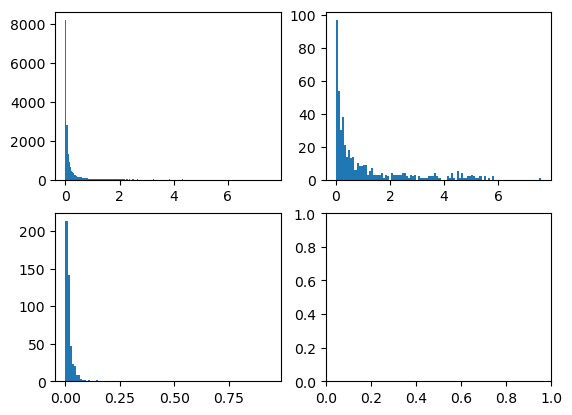

In [49]:
# activity =
import numpy as np

act_masked = np.ma.masked_array(neuron_activity, mask=neuron_activity == 0)
act_masked = np.ma.filled(act_masked, np.nan)
print(neuron_activity)
print(act_masked)
fig, axes = plt.subplots(2, 2)
axes[0][0].hist(neuron_activity[neuron_activity > 0], bins=200)
axes[0][1].hist(np.nanmax(act_masked, axis=1), bins=100)
axes[1][0].hist(np.nanpercentile(act_masked, 20, axis=1), bins=100)
plt.show()

# test namras method

In [9]:
from placefield_detection.alternative_detection_methods.thresholding_pf_method import (
    thresholding_method_single,
    thresholding_method_batch,
)


# print(neuron_activity.shape)
# results = thresholding_method_single(behavior, ld["S"][3, :], plot=True)
results = thresholding_method_single(behavior, neuron_activity[11, :], plot=True)
results
# place_fields = thresholding_method_batch(behavior, neuron_activity, sigma=2)

NameError: name 'neuron_activity' is not defined

In [ ]:
behavior["dwelltime"].shape

(40,)

{}


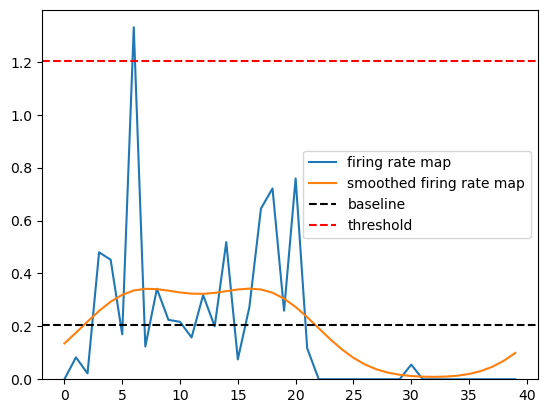

In [118]:
for neuron in range(1):
    field = thresholding_method_single(
        behavior, neuron_activity[neuron, :], threshold_factor=4, sigma=4, plot=True
    )
    print(field)
# field = thresholding_method_single(
#     behavior, neuron_activity[4, :], sigma=2, plot=True
# )
# field